In [1]:
%load_ext autoreload
%autoreload all

# from multiprocessing.pool import ThreadPool as Pool
from multiprocessing.pool import Pool
from multiprocessing import freeze_support

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from snn_dpe.tools.data import Mackey_Glass, util
from snn_dpe.tools.network import create_network
from snn_dpe.tools.plotting import *
from snn_dpe.tools.train.timeseries import train_TS

freeze_support()

In [2]:
MG_data_tr = Mackey_Glass.read_MG_data('../../Data/MarkusThill-MGAB-60f6b17/1.csv', normalize=True)
MG_data_te = Mackey_Glass.read_MG_data('../../Data/MarkusThill-MGAB-60f6b17/2.csv', normalize=True)

# slice up MG into input, output pairs
input_window_size = 10
output_window_size = 1

# max here is 10,000 since that's the length of the csv
n_tr_data = 2000
n_te_data = 2000

MG_inputs_tr, MG_outputs_tr = util.generate_io_pairs(MG_data_tr[:n_tr_data], input_window_size, output_window_size)
MG_inputs_te, MG_outputs_te = util.generate_io_pairs(MG_data_te[:n_te_data], input_window_size, output_window_size)


def run_test(args):
    tr_mses = []
    te_mses = []

    noise_axis = np.linspace(0, 0.1, num=3)

    for n in noise_axis:

        # create a test network
        n_neurons = 30
        synapse_density = 0.1
        n_input = 12 #how many neurons will receive potentiation adjustments related to MG
        n_synapses = int((n_neurons**2)*synapse_density)

        # dpe noise
        write_noise = 0
        # synapse parameters
        drift = 0
        synapse_noise = n

        # training parameters
        n_epochs = 2
        post_sample_reset = True #also applies to testing
        reset_synapses = True #also applies to testing
        post_epoch_reset = False

        neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.25), weight_factor = 1, std_dev=synapse_noise, drift = drift)
        # train
        training_mses, testing_mses, _, _ = train_TS(n_epochs, MG_inputs_tr, MG_outputs_tr, neurons, n_input, silent=True, TS_inputs_te=MG_inputs_te, TS_outputs_te=MG_outputs_te, relative=True, write_noise_std=write_noise, post_sample_reset=post_sample_reset, reset_synapses=reset_synapses, post_epoch_reset=post_epoch_reset)
        
        # save the final mses of the last epoch
        tr_mses.append(training_mses[-1])
        te_mses.append(testing_mses[-1])

    return tr_mses, te_mses, noise_axis


n_tests = 5
n_threads = 5
with Pool(processes=n_threads) as p:
    results = list(tqdm(p.imap(run_test, range(n_tests)), total=n_tests))
    


100%|██████████| 5/5 [01:08<00:00, 13.61s/it]


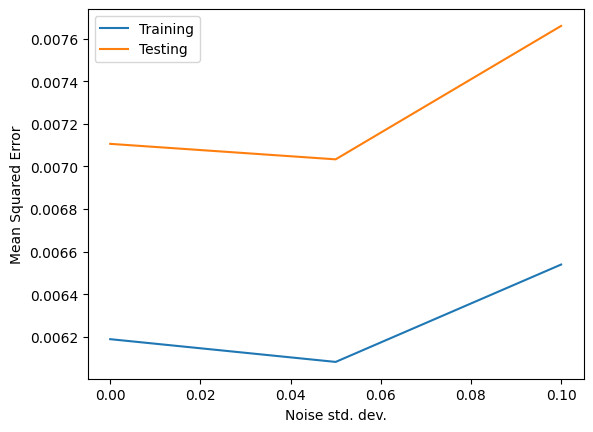

In [4]:
(tr_mses, te_mses, noise_axis) = np.mean(results, axis=0)


plt.plot(noise_axis, tr_mses, label='Training')
plt.plot(noise_axis, te_mses, label='Testing')
plt.legend()
plt.xlabel('Noise std. dev.')
plt.ylabel('Mean Squared Error')
# plt.ylim(0, 100)
# plt.yscale('log')
plt.show()